# Rating Prediction

As the motivation and the principle of this sub-project have been introduced before, this notebook will start with a section about data understanding.

### Data Understanding
In what follows, this notebook will look at what textual data which can be found in the listing data and plan the further steps for the textual analysis.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from math import floor

from utility import concat_to_single, score_binning

In [2]:
# Get dataframes and concatenate
boston_df = pd.read_csv('listings_boston.csv')
seattle_df = pd.read_csv('listings_seattle.csv')
main_df = pd.concat([boston_df,seattle_df],sort=False).reset_index().drop('index',axis=1)

In [3]:
# Show head
main_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


##### Summary
One can see, that there are in total 9 features that are textual descriptions of the characteristics of the object, provided by the host. Although the feature 'name' is not technically a textual description, but rather a title, it does contain some descriptive information, mostly in the form of adjectives, which are likely supposed to advertise the qualities of the object. Therefore, the 'name' is also included as a feature.

### Data Preparation
To get features, with which the ratings can be predicted, the textual features, including the name, will be concatenated to a single string, which will the be transformed to numerical features via a CountVectorizer. Since a CountVectorizer has a  tendency of creating a high number of features, the dimensionality will be reduced to one tenth of the number of features.

Furthermore, the model will not attempt to predict the ratings as a continous variable, but rather the 'bin' of the rating.

As we see further down, the data will be very imbalanced, the training set will be oversampled, while the test set will be used as is.

In [4]:
# Get text columns
text_columns = ['name','summary','space','description','neighborhood_overview',
                'notes','transit','access','interaction','house_rules']

In [5]:
# Concatenate text_columns to single feature
main_df['text_features'] = main_df.loc[:,text_columns].apply(concat_to_single,axis=1)

In [6]:
# Bin review scores ratings
main_df['rating_bin'] = main_df['review_scores_rating'].map(score_binning)

In [7]:
# Get matrices
X_raw = main_df.loc[:,'text_features'].values
y = main_df.loc[:,'rating_bin'].astype('int').values

In [8]:
# Instantiate CountVectorizer and PCA and make pipeline
vectorizer = CountVectorizer(strip_accents='unicode',stop_words='english')
tsvd = TruncatedSVD(n_components=floor(len(y)/10))
pipe = make_pipeline(vectorizer,tsvd)

In [9]:
# Transform data and split
X = pipe.fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)

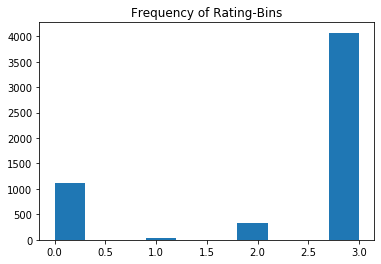

In [10]:
# Check for imbalance in y_train
plt.hist(y_train)
plt.title('Frequency of Rating-Bins')
plt.savefig('imb_main')

(array([4069.,    0.,    0., 4069.,    0.,    0., 4069.,    0.,    0.,
        4069.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

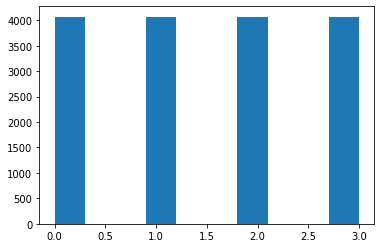

In [11]:
# Resample imbalanced data
X_train_re, y_train_re = SMOTE(sampling_strategy='not majority').fit_resample(X_train, y_train)
plt.hist(y_train_re)

### Data modelling
As the data has now been sufficiently prepared, it is now time to train a model on it and evaluate the model on the testing set.

In [12]:
# Train and evaluate model
gradboost = GradientBoostingClassifier()
gradboost.fit(X_train_re,y_train_re)
y_prime = gradboost.predict(X_train_re)
y_hat = gradboost.predict(X_test)

print('Training Accuracy: {}'.format(accuracy_score(y_train_re,y_prime)))
print('Training F1 Score: {}'.format(f1_score(y_train_re,y_prime,average='weighted')))
print('Test Accuracy: {}'.format(accuracy_score(y_test,y_hat)))
print('Test F1 Score: {}'.format(f1_score(y_test,y_hat,average='weighted')))

Training Accuracy: 0.9142295404276235
Training F1 Score: 0.9138980994074216
Test Accuracy: 0.678011885467315
Test F1 Score: 0.6855613386969096


In [13]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test,y_hat))

,0,1,2,3
0,151,6,49,164
1,6,0,4,6
2,23,3,22,59
3,198,6,72,1082


### Conclusion
As the above confusion matrix shows, it is possible, to predict the approximate range of the reviews to some extent, however, to reach a more satisfying result, a more sophisticated model or series of models could be developed, but that would be outside the scope of this notebook.